# Building RNN with Pytorch

Dans ce TD, nous allons construire un RNN from scratch avec Pytorch, en suivant les étapes suivantes:
1. Sur un problème linéaire, nous allons utiliser les torch optimizers pour trouver le paramètre de régression idéal
2. Sur un problème non-linéaire, nous allons construire un multi-layers perceptron
3. Sur un problème de texte, nous allons construire un modèle RNN

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from transformers import AutoTokenizer

c:\Users\Thoma\miniconda3\envs\NLP\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Optimizers

### Données example
Nous allons construire des données $y = \beta^* X + b$


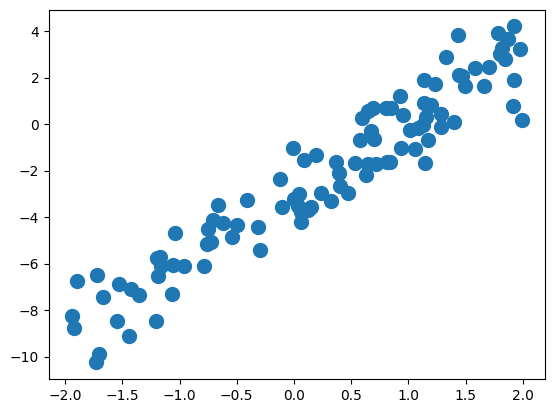

In [2]:
n = 100

a_star = 3.
b_star = -3.
noise_std = 1

x = (np.random.rand(n, 1) - 0.5) * 4
noise = np.random.normal(0, noise_std, (n, 1))
y = a_star * x + b_star + noise

x = torch.tensor(x, dtype=torch.float32)

xvec = x
plt.plot(x, y, "o", markersize=10)

### Constuire l'optimizer

- Avec torch.nn.Parameter(), créer le paramètre beta qui sera optimisé. Les predictions du modèle sont égales à $\beta \times X$ 
- Avec torch.nn.MSELoss, déclarer la loss entre les prédictions et le résultat réel. loss.backward() pour mettre à jour les gradients
- Avec torch.optim.Adam, déclarer un optimizer
- Construisez la boucle qui, pour n_epochs, va reset les gradients, calculer la loss, mettre à jour les gradients et faire un pas pour optimiser beta

In [3]:
y = torch.tensor(y, dtype=torch.float32)

n_epochs = 1000

# create beta parameter
beta = nn.Parameter(torch.randn(1, 1, requires_grad=True))

# create mean squared error loss function
mse_loss = nn.MSELoss()

# create Adam optimizer
optimizer = optim.Adam([beta], lr=0.01)

# train loop
for epoch in range(n_epochs):
    optimizer.zero_grad()  # reset gradients
    y_pred = beta * x  # make predictions
    loss = mse_loss(y_pred, y)  # calculate loss
    loss.backward()  # calculate gradients
    optimizer.step()  # update beta


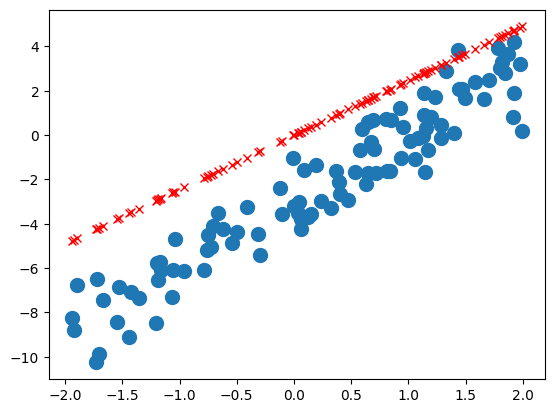

In [4]:
# Plot des predictions
plt.plot(x, y, 'o', markersize=10)
plt.plot(x, beta.item() * x, 'rx')

## Construire un multi-layer perceptron (MLP)

Ici, les données sont $y = a x^2 + b$

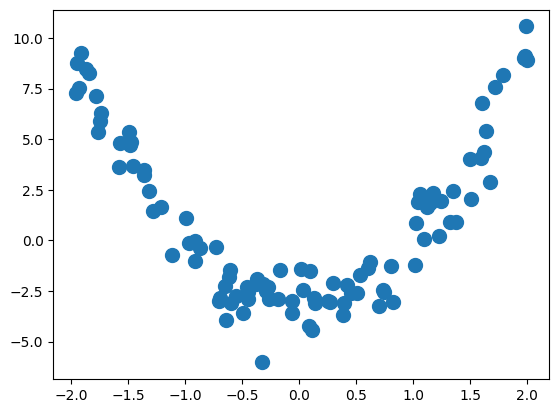

In [5]:
n = 100

a_star = 3.
b_star = -3.
noise_std = 1

x = (np.random.rand(n, 1) - 0.5) * 4
noise = np.random.normal(0, noise_std, (n, 1))
y = a_star * (x ** 2) + b_star + noise

x = torch.tensor(x, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32)

xvec = x
plt.plot(x, y, 'o', markersize=10)

Nous allons construire un Pytorch modèle. Dans ce framework, on définit la fonction "forward" qui prend en argument les inputs et retourne les prédictions.

A l'aide de torch.nn.Module et de différentes layers (torch.nn.Linear, torch.nn.ReLU), terminez la classe ci-dessous pour créer un multi-layers perceptron 

In [6]:
class MLP(torch.nn.Module):
    def __init__(self, input_size):
        super().__init__()
        prev_size = input_size
        
        hidden_size = 64
        self.layer = torch.nn.Linear(input_size, hidden_size)
        self.relu = torch.nn.ReLU()
        self.layer2 = torch.nn.Linear(hidden_size, 1)

    def forward(self, X):
        X = self.layer(X)
        X = self.relu(X)
        X = self.layer2(X)
        
        return X

En utilisant le travail précédent, faite une cellule utilisant un torch optimizer pour optimiser le MLP 

In [7]:
model = MLP(input_size=1) 

loss_fn = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

for epoch in range(100):
    optimizer.zero_grad()
    y_pred = model(x)
    loss = loss_fn(y_pred, y)
    loss.backward()
    optimizer.step()


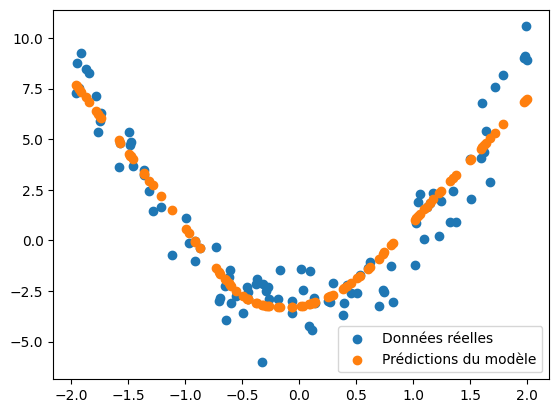

In [8]:
x_np = x.detach().numpy()
y_np = y.detach().numpy()
y_pred_np = model(x).detach().numpy()
plt.scatter(x_np, y_np, label='Données réelles')
plt.scatter(x_np, y_pred_np, label='Prédictions du modèle')
plt.legend()

## Construire un Recurrent Neural Network (RNN) from scratch

### Données
 
Téléchargez [ici](https://download.pytorch.org/tutorial/data.zip) un jeu de données "nom" -> pays d'origine du nom.
Les noms de chaque pays sont dans leur fichier texte "[country].txt"

A partir de ces données, créez X la liste des noms et y le pays d'origine de chaque nom

### Aide pour générer les données

A la fin de ce code, on lit les noms et leur pays d'origine.<br>
On a une fonction randomTrainingExample, qui génère le pays d'origine et le nom (en texte), puis l'ID de ce pays et le tenseur représetant le nom. <br>

A partir de là, vous pouvez générer les données X, y comme vous voulez

In [9]:
# Code pour générer le jeu de données
# En admettant que les fichiers ont été extraits dans data/raw/names/

import math
import numpy as np
from pathlib import Path
import random
import string
import time
import unicodedata

path = Path("../src/data/raw/names/")

In [10]:
def read_names(path):
    category_lines = {}
    for file in path.iterdir():
        if not file.name.endswith(".txt"):
            continue
            
        with open(file) as f:
            names = [unicodeToAscii(line.strip()) for line in f]
        
        category = file.stem
        category_lines[category] = names

    return category_lines

# Handling ASCII stuff
all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

# Turn a Unicode string to plain ASCII, thanks to https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

In [11]:
category_lines = read_names(path)
all_categories = list(category_lines.keys())
n_categories = len(all_categories)

In [12]:
import torch

# Find letter index from all_letters, e.g. "a" = 0
def letterToIndex(letter):
    return all_letters.find(letter)

# Just for demonstration, turn a letter into a <1 x n_letters> Tensor
def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor

# Turn a line into a <line_length x 1 x n_letters>,
# or an array of one-hot letter vectors
def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

In [13]:
def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor

for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print('category =', category, '/ line =', line)

category = Scottish / line = Wilson
category = Portuguese / line = Pereira
category = Vietnamese / line = Giang
category = Portuguese / line = Costa
category = French / line = Gosse
category = Japanese / line = Ikoma
category = French / line = Lamar
category = Greek / line = Kotsilimbas
category = Vietnamese / line = Chu
category = Czech / line = Hanek


### Construire le RNN

Un Recurrent Neural Network prend, pour prédire un input X et un hidden state H.<br>
Il output une prédiction et un nouvel hidden state pour la prochaine étape.<br>
Nous allons construire un modèle:

$f(name, H_0) = (proba(\mbox{name from country 0}), proba(\mbox{name from country 1}), \dots)$

Avec $H_0$ un hidden state initial (qui sera appris).

Pour l'instant, nous allons construire un RNN linéaire.<br>
Comme pour le MLP, construisez un torch.nn.Module:
- A l'init, la classe prendra les arguments input_size, hidden_state_dim, output_size
- L'init déclare un paramètre pour l'hidden state initial $H_0$, une layer linéaire prenant (input, hidden_state) -> output_size
- Le forward fonctionnera ainsi:
    - hidden_state = $H_0$
    - For letter in name:
        - x = one-hot encode (letter)
        - output, hidden_state = linear_layer(x, hidden_state)
    - return softmax(output)


In [17]:
class RNN(torch.nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size

        self.i2h = torch.nn.Linear(input_size + hidden_size, hidden_size)
        self.h2o = torch.nn.Linear(hidden_size, output_size)
        self.softmax = torch.nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.h2o(hidden)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)
    
    def train(self, category_tensor, line_tensor, criterion, learning_rate=0.005):
        hidden = self.initHidden()

        self.zero_grad()

        for i in range(line_tensor.size()[0]):
            output, hidden = self(line_tensor[i], hidden)

        loss = criterion(output, category_tensor)
        loss.backward()

        for p in self.parameters():
            p.data.add_(p.grad.data, alpha=-learning_rate)

        return output, loss.item()

A l'aide de la negative log likelihood (torch.nn.NLLLoss), construisez une boucle optimisant ce modèle (optimizer, itération au sein des examples).

**Attention 1:** Ici, on n'a pas des tenseurs X, y. On va prendre les exemples 1 par 1.<br>
**Attention 2:** Si le modèle apprend les examples dans l'ordre (d'abord tous les noms arabes, puis tous les chinois, puis tous les tchèques, etc), cela changera grandement le résulat (et le modèle sera très mauvais)

Époque 1000: Loss = 2.8319153785705566
Époque 2000: Loss = 2.942162036895752
Époque 3000: Loss = 2.9836955070495605
Époque 4000: Loss = 2.835639715194702
Époque 5000: Loss = 2.662506103515625
Époque 6000: Loss = 2.9785094261169434
Époque 7000: Loss = 2.7332937717437744
Époque 8000: Loss = 2.6033153533935547
Époque 9000: Loss = 2.8830833435058594


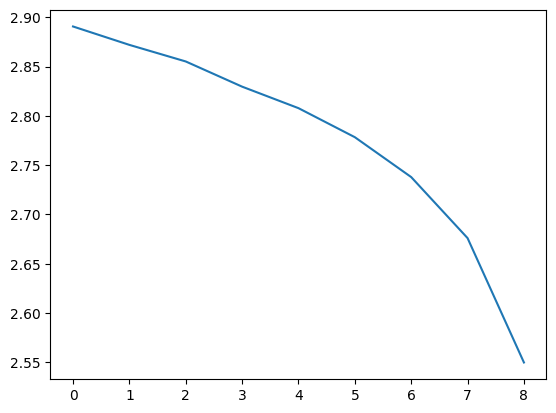

In [21]:
l_rates = 0.003
n_epochs = 10000

hidden_size = 128
output_size = n_categories


model = RNN(input_size=n_letters, hidden_size=hidden_size, output_size=output_size)

criterion = torch.nn.NLLLoss()

current_loss = 0
all_losses = []

for epoch in range(1, n_epochs + 0):
    category, line, category_tensor, line_tensor = randomTrainingExample()

    output, loss = model.train(category_tensor, line_tensor, criterion, learning_rate=l_rates)

    current_loss += loss

    if epoch % 1000 == 0:
        print(f'Époque {epoch}: Loss = {loss}')
        all_losses.append(current_loss / 1000)
        current_loss = 0

plt.figure()
plt.plot(all_losses)

## Utilisez les RNNs de Pytorch

Sur le même jeu de données, nous allons utiliser les RNNs déjà codés par Pytorch.<br>

### Padding

Nous voulons aussi utiliser des tenseurs X et y pour utiliser data loader pour les batchs, etc


Avec du padding, créer un tenseur X de la taille (nb_data, name_max_length, vocab_size). <br>
X[i, j, :] contient le one-hot encode de la j-ème lettre du i-ème prénom. Si le i-ème prénom a moins de j lettre, alors X[i, j, :] est un vecteur nul

In [22]:
name_max_length = 19

last_names = []

vocab = {letter: index for index, letter in enumerate("abcdefghijklmnopqrstuvwxyz', ")}

vocab2 = {letter: index for index, letter in enumerate("ABCDEFGHIJKLMNOPQRSTUVWXYZ")}

vocab_size = len(vocab)

vocab.update(vocab2)

country_to_index = {country: index for index, country in enumerate(category_lines.keys())}

for country, names in category_lines.items():
    last_names.extend([(country, name) for name in names])

nb_data = len(last_names)

X = np.zeros((nb_data, name_max_length, vocab_size), dtype=np.float32)
Y = np.zeros((nb_data, n_categories))

for i, (country, name) in enumerate(last_names):
    for j, letter in enumerate(name):
        if j >= name_max_length:
            raise ValueError(f"Name {name} is too long")
        if letter in vocab:
            X[i, j, vocab[letter]] = 1.0
        else:
            print(f"Letter {letter} not in vocab")

    Y[i][country_to_index[country]] = 1.0

X = torch.Tensor(X)
Y = torch.Tensor(Y)

Y = Y.type(torch.LongTensor)

print(X.shape)
print(Y.shape)

torch.Size([20074, 19, 29])
torch.Size([20074, 18])


### Modèle

Construisez un modèle qui:
- A l'init, déclare un hidden state initial $H_0$, un RNN (avec torch.nn.RNN)
- Au forward, passe (input, $H_0$) dans le RNN, puis applique un softmax à l'output

In [25]:
class RNNModel(torch.nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNNModel, self).__init__()
        self.hidden_size = hidden_size
        self.rnn = torch.nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc = torch.nn.Linear(hidden_size, output_size)
        self.softmax = torch.nn.LogSoftmax(dim=1)
        
    def forward(self, x):
        out, _ = self.rnn(x)
        out = self.fc(out[:, -1, :])
        out = self.softmax(out)

        return out

from torch.utils.data import DataLoader, Dataset

class CustomDataset(Dataset):
    def __init__(self, X, Y):
        self.X = X
        self.Y = Y
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]

Entraînez le modèle avec des batchs de X, y

Epoch 0: Loss = 2.4783763885498047
Epoch 5: Loss = 1.8881707191467285
Epoch 10: Loss = 1.9901702404022217
Epoch 15: Loss = 2.0403003692626953
Epoch 20: Loss = 1.596028447151184
Epoch 25: Loss = 1.3533952236175537
Epoch 30: Loss = 1.891557216644287
Epoch 35: Loss = 1.6432019472122192
Epoch 40: Loss = 1.459503412246704
Epoch 45: Loss = 1.4440922737121582
Epoch 50: Loss = 1.8964860439300537
Epoch 55: Loss = 1.3812845945358276
Epoch 60: Loss = 1.5330981016159058
Epoch 65: Loss = 1.6730448007583618
Epoch 70: Loss = 1.0996118783950806
Epoch 75: Loss = 1.0124573707580566
Epoch 80: Loss = 0.6589623689651489
Epoch 85: Loss = 1.0879652500152588
Epoch 90: Loss = 1.1967402696609497
Epoch 95: Loss = 0.739730715751648


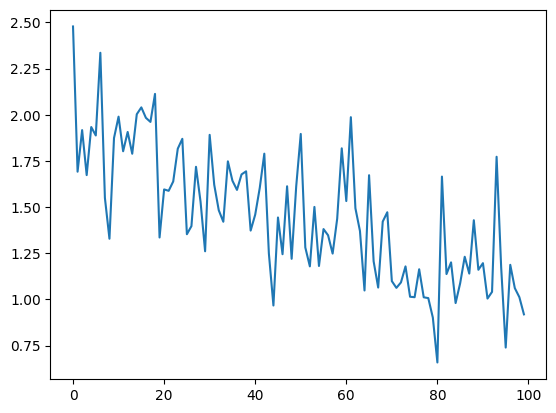

In [26]:
input_size = vocab_size
hidden_size = 64
output_size = n_categories
batch_size = 64
learning_rate = 0.001
num_epochs = 100

dataset = CustomDataset(X, Y)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

model = RNNModel(input_size, hidden_size, output_size)
criterion = torch.nn.NLLLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

all_losses = []
for epoch in range(num_epochs):
    for inputs, labels in dataloader:
        optimizer.zero_grad()
        
        outputs = model(inputs)
        
        loss = criterion(outputs, torch.max(labels, 1)[1])
        
        loss.backward()
        optimizer.step()
    if epoch % 5 == 0:
        print(f'Epoch {epoch}: Loss = {loss.item()}')
    all_losses.append(loss.item())

plt.figure()
plt.plot(all_losses)

### Amélioration du modèle

Tenter d'améliorer le modèle:
- En utilisant plusieurs layers dans le RNN
- En utilisant LSTM à la place de RNN (une autre forme de recurrent neural network, plus avancé)

(regardez la doc)

In [27]:
class LSTMModel(torch.nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = torch.nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = torch.nn.Linear(hidden_size, output_size)
        self.softmax = torch.nn.LogSoftmax(dim=1)
    
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        out = self.softmax(out)
        
        return out

Epoch 0: Loss = 1.7155036926269531
Epoch 5: Loss = 0.7907418608665466
Epoch 10: Loss = 0.6248751878738403
Epoch 15: Loss = 0.785868227481842
Epoch 20: Loss = 0.8011077642440796
Epoch 25: Loss = 0.5631098747253418
Epoch 30: Loss = 0.39784350991249084
Epoch 35: Loss = 0.5991265177726746
Epoch 40: Loss = 0.448231965303421
Epoch 45: Loss = 0.2241656631231308
Epoch 50: Loss = 0.2229299247264862
Epoch 55: Loss = 0.3509555757045746
Epoch 60: Loss = 0.17595012485980988
Epoch 65: Loss = 0.24761506915092468
Epoch 70: Loss = 0.5040162205696106
Epoch 75: Loss = 0.21759340167045593
Epoch 80: Loss = 0.09664444625377655
Epoch 85: Loss = 0.28116926550865173
Epoch 90: Loss = 0.42707589268684387
Epoch 95: Loss = 0.14570315182209015


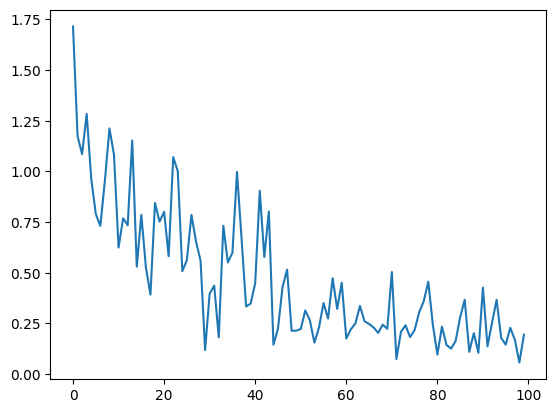

In [28]:
input_size = vocab_size
hidden_size = 64
num_layers = 2
output_size = n_categories
batch_size = 64
learning_rate = 0.001
num_epochs = 100

dataset = CustomDataset(X, Y)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

model = LSTMModel(input_size, hidden_size, num_layers, output_size)
criterion = torch.nn.NLLLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

all_losses = []
for epoch in range(num_epochs):
    for inputs, labels in dataloader:
        optimizer.zero_grad()
        
        outputs = model(inputs)
        
        loss = criterion(outputs, torch.max(labels, 1)[1])
        
        loss.backward()
        optimizer.step()

    if epoch % 5 == 0:
        print(f'Epoch {epoch}: Loss = {loss.item()}')
        
    all_losses.append(loss.item())

plt.figure()
plt.plot(all_losses)

### Embedding

On veut utiliser en embedding pour les lettres.
Le forward appliquerait l'embedding aux lettres, puis les layers RNN prendrait l'embedding comme input

Nous allons utiliser torch.nn.Embedding
**Attention**: Embedding ne prend pas les lettres one-hot encoded, mais leurs indices.
Par exemple, "abca", il lui faudrait le vecteur [0, 1, 2, 0]<br>
et non [[1, 0, 0], [0, 1, 0], [0, 0, 1], [1, 0, 0]]

**Expérimenter torch.nn.Embedding**<br>
Instantier "emb" une torch.nn.Embedding avec les bons paramètres (regardez la doc)
En construisant le bon tenseur X_emb,

```emb(X_emb)```

doit retourner un tenseur (qui n'a pas de sens car il n'a rien appris pour l'instant, mais les opérations se passent bien)

In [29]:
X_indices = [0, 1, 2, 0]
alphabet_size = 29
embedding_dim = 10 

emb = torch.nn.Embedding(alphabet_size, embedding_dim)

X_index_tensor = torch.tensor(X_indices, dtype=torch.long)
X_emb = emb(X_index_tensor)

print(X_emb)

tensor([[ 0.2161,  0.1473,  0.2122,  0.1844,  0.4874, -0.1927, -0.5083, -0.2418,
         -0.2102,  1.6535],
        [ 0.5304,  1.4955,  0.4607, -0.1124,  2.7745, -0.3864, -1.4430,  0.6468,
          1.3385, -2.4216],
        [-0.5740, -1.9255, -0.0356,  0.1620,  1.3807,  0.5791,  1.5375,  0.2223,
         -0.6433, -0.2516],
        [ 0.2161,  0.1473,  0.2122,  0.1844,  0.4874, -0.1927, -0.5083, -0.2418,
         -0.2102,  1.6535]], grad_fn=<EmbeddingBackward0>)


Construisez un modèle RNN, où les lettres passent par l'embedding avant d'être envoyées dans les couches de RNN.
Construisez une loop d'apprentissage

Expérimentez plusieurs valeurs pour le nombre de couche, la taille d'embedding ou les tailles d'hidden state.<br>
Quel neg log likelihood obtenez-vous ?

In [30]:
name_max_length = 19
last_names = []
vocab = {letter: index for index, letter in enumerate("abcdefghijklmnopqrstuvwxyz', ")}
vocab2 = {letter: index for index, letter in enumerate("ABCDEFGHIJKLMNOPQRSTUVWXYZ")}
vocab_size = len(vocab)
vocab.update(vocab2)
country_to_index = {country: index for index, country in enumerate(category_lines.keys())}

for country, names in category_lines.items():
    last_names.extend([(country, name) for name in names])

nb_data = len(last_names)

X = np.zeros((nb_data, name_max_length))
Y = []

for i, (country, name) in enumerate(last_names):
    for j, letter in enumerate(name):
        if j >= name_max_length:
            raise ValueError(f"Name {name} is too long")
        if letter in vocab:
            X[i, j] = vocab[letter]
        else:
            print(f"Letter {letter} not in vocab")

    Y.append(country_to_index[country])

X = torch.Tensor(X)
Y = torch.Tensor(Y)

X = X.type(torch.LongTensor)
Y = Y.type(torch.LongTensor)

print(X.shape)
print(Y.shape)

torch.Size([20074, 19])
torch.Size([20074])


In [31]:
from torch.utils.data.dataset import random_split


class RNNWithEmbedding(torch.nn.Module):
    def __init__(self, alphabet_size, embedding_dim, hidden_size, num_layers, output_size):
        super(RNNWithEmbedding, self).__init__()
        self.embedding = torch.nn.Embedding(alphabet_size, embedding_dim)
        self.rnn = torch.nn.LSTM(embedding_dim, hidden_size, num_layers, batch_first=True)
        self.fc = torch.nn.Linear(hidden_size, output_size)
        self.softmax = torch.nn.LogSoftmax(dim=1)
    
    def forward(self, x):
        x = self.embedding(x)
        out, _ = self.rnn(x)
        out = self.fc(out[:, -1, :])
        out = self.softmax(out)
        
        return out
    
    def launch_training(self, X, Y, criterion, optimizer, batch_size=64, num_epochs=100, validation_split=0.2, shuffle_dataset=True):

        dataset = CustomDataset(X, Y)

        dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle_dataset)

        total_size = len(dataloader.dataset)
        train_size = int((1 - validation_split) * total_size)
        val_size = total_size - train_size

        train_dataset, val_dataset = random_split(dataloader.dataset, [train_size, val_size])

        train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

        train_losses = []
        val_losses = []

        for epoch in range(num_epochs):
            for inputs, labels in train_dataloader:
                optimizer.zero_grad()
                
                outputs = self(inputs)
                
                loss = criterion(outputs, labels)

                loss.backward()
                optimizer.step()

            # Evaluation
            self.eval()
            with torch.no_grad():
                for inputs, labels in val_dataloader:
                    outputs = self(inputs)
                    val_loss = criterion(outputs, labels)
                    
            self.train()
            
            if epoch % 5 == 0:
                print(f'Epoch {epoch}: Training Loss = {loss.item()} - Val Loss = {val_loss.item()}')
                
            train_losses.append(loss.item())
            val_losses.append(val_loss.item())
        
        return train_losses, val_losses


In [32]:
alphabet_size = vocab_size
output_size = n_categories
num_epochs = 100
batch_size = 64

learning_rate = 0.001
embedding_dim = 32
hidden_size = 64
num_layers = 2

model = RNNWithEmbedding(alphabet_size, embedding_dim, hidden_size, num_layers, output_size)
criterion = torch.nn.NLLLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

train_losses, val_losses = model.launch_training(X, Y, criterion, optimizer, batch_size, num_epochs)

Epoch 0: Training Loss = 1.9165313243865967 - Val Loss = 2.023486852645874
Epoch 5: Training Loss = 1.0671141147613525 - Val Loss = 1.2416647672653198
Epoch 10: Training Loss = 0.6388108730316162 - Val Loss = 1.0205512046813965
Epoch 15: Training Loss = 0.6881833672523499 - Val Loss = 0.8980385661125183
Epoch 20: Training Loss = 0.528007984161377 - Val Loss = 1.0686008930206299
Epoch 25: Training Loss = 0.3268496096134186 - Val Loss = 1.0870734453201294
Epoch 30: Training Loss = 0.3321933150291443 - Val Loss = 0.9723721146583557
Epoch 35: Training Loss = 0.3147728443145752 - Val Loss = 1.0298326015472412
Epoch 40: Training Loss = 0.2585032284259796 - Val Loss = 0.9724675416946411
Epoch 45: Training Loss = 0.20133113861083984 - Val Loss = 1.2453416585922241
Epoch 50: Training Loss = 0.2298462986946106 - Val Loss = 1.594416856765747
Epoch 55: Training Loss = 0.14491258561611176 - Val Loss = 1.356089472770691
Epoch 60: Training Loss = 0.10611870884895325 - Val Loss = 1.3593980073928833
Ep

Text(0, 0.5, 'Loss')

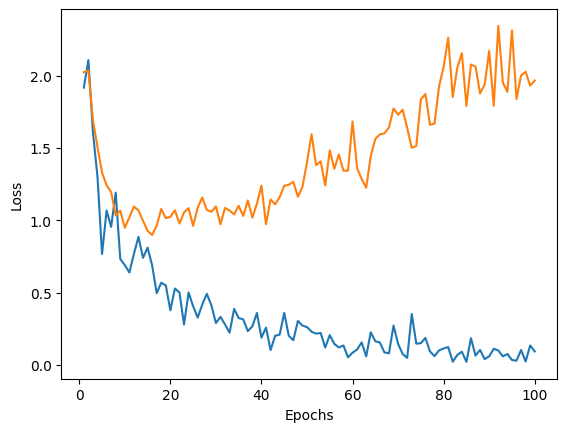

In [33]:
iterations = range(1, len(train_losses) + 1)

plt.plot(iterations, train_losses, label='Train Loss')
plt.plot(iterations, val_losses, label='Validation Loss')

plt.xlabel('Epochs')
plt.ylabel('Loss')